In [11]:
# Load the Iris dataset from local .csv file
# dataset can be founded in here : https://gist.github.com/netj/8836201
import pandas as pd
import numpy as np

filename = 'iris.csv'
df = pd.read_csv(filename)

# Create feature set : X by drop label column in dataframe
X=df.drop('variety', axis=1)
X = X.values

# Label the output classes
# Since Setosa and Versicolor are linearly separable and between Setosa and Virginica too,
# We will do the binary classification between Setosa (0) and group of Versicolor + Virginica (1)
y=df['variety']
y = y.values.reshape(150, 1)

l_y = []
for i in range(len(y)):
    if y[i, 0] == 'Setosa':
        l_y.append([1, 0, 0])
    elif y[i, 0] == 'Versicolor':
        l_y.append([0, 1, 0])
    elif y[i, 0] == 'Virginica':
        l_y.append([0, 0, 1])
y = np.array(l_y)

# convert data into pytorch tensor
import torch
X = torch.Tensor(X)
y = torch.Tensor(y)
#print(X)
#print(y)
print(X.shape, X.dtype)
print(y.shape, y.dtype)

torch.Size([150, 4]) torch.float32
torch.Size([150, 3]) torch.float32


In [12]:
# Create NN model using PyTorch
import torch
from torch import nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer_out = nn.Linear(hidden_size, output_size)
        self.activation_fn = nn.Sigmoid()
        
    def forward(self, x):
        z1 = self.layer1(x)
        a1 = self.activation_fn(z1)
        z_out = self.layer_out(a1)
        y = nn.Softmax(dim=1)(z_out)
        return y

model_iris = MLP(4, 8, 3)
print(model_iris)

MLP(
  (layer1): Linear(in_features=4, out_features=8, bias=True)
  (layer_out): Linear(in_features=8, out_features=3, bias=True)
  (activation_fn): Sigmoid()
)


In [13]:
# Prepare the data
# Split the data into training set and testing set
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# pack the feature X and output y together
train_ds = TensorDataset(X_train, y_train)

# create the training data, batch size.
batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [14]:
# Training
from torch.optim import SGD

# hyperparameters
learning_rate = 0.002
momentum = 0.1

# Loss function
loss_fn = nn.MSELoss(reduction='mean')
# Stochastic Gradient Descent (SGD) as optimizer in training procedure
# 
# v = momentum * v - lr * grad(w)
# w = w + v
optimizer = SGD(model_iris.parameters(), lr=learning_rate, momentum=momentum)

num_epochs = 1000
# Start iterate for model training
loss_arr = []
for epoch in range(num_epochs):
    for batch_idx, train_data in enumerate(train_dl):
        x_batch, y_batch = train_data
        # 0. Reset the gradients to zero
        optimizer.zero_grad()
        # 1. Generate predictions
        predict = model_iris.forward(x_batch)
        # 2. Calculate loss
        loss = loss_fn(predict, y_batch)
        # 3. Compute gradients
        loss.backward()
        # 4. Update parameters using gradients
        optimizer.step()
    if epoch % (num_epochs/10) == 0:
        print(f'Epoch {epoch} Loss {loss.item():.4f}')
    loss_arr.append(loss.item())

Epoch 0 Loss 0.2343
Epoch 100 Loss 0.1737
Epoch 200 Loss 0.1615
Epoch 300 Loss 0.1196
Epoch 400 Loss 0.1111
Epoch 500 Loss 0.0875
Epoch 600 Loss 0.0956
Epoch 700 Loss 0.1143
Epoch 800 Loss 0.0736
Epoch 900 Loss 0.1028


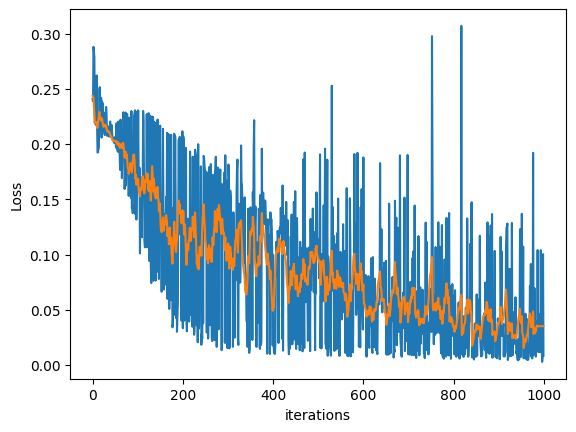

In [12]:
# Plot the epoch vs loss 
import matplotlib.pyplot as plt

# calculate moving average of loss
def wma(data, window_size):
    weights = np.arange(1, window_size + 1)
    return list(np.convolve(data, weights, mode='valid') / weights.sum())
loss_avg_arr = []
window_size=15
loss_avg_arr = wma(loss_arr, window_size)
for i in range(window_size - 1):
    loss_avg_arr.append(loss_avg_arr[-1])
plt.plot(list(range(num_epochs)), loss_arr)
plt.plot(list(range(num_epochs)), loss_avg_arr)
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.show()

In [13]:
# Testing resulted model by measuring the accuracy
# accuracy = num of correction / num of total prediction

correct = 0
total = y_test.shape[0]
y_predict = model_iris.forward(X_test)
for i in range(total):
    # compare the predicted output with the actual output 
    # by using the indices of the maximum value in the output layer
    val_predict, indices_predict = torch.max(y_predict[i, :], 0)
    val_actual, indices_actual = torch.max(y_test[i, :], 0)
    if indices_predict == indices_actual:
        correct += 1
print("number of correction=", correct, " out of ", total, ", accuracy=", correct/total)
    

number of correction= 30  out of  30 , accuracy= 1.0


In [7]:
# Save the model in PyTorch .pth file with its current state
path = 'model_iris.pth'
torch.save(model_iris, path)